### Sample Notebook Comparing MDF And PyTorch Model

This notebook demonstrate how the pytorch model created in the previous notebook was converted to MDF and the graphical representation of the MDF was created, and then the MDF model was saved in both json and yaml file format.

### Importing libraries

In [1]:
# importing pytorch packages needed for this project
from torchvision import transforms
import torch
import torchvision.models as models
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np

In [2]:
# importing MDF packages
from modeci_mdf.interfaces.pytorch import pytorch_to_mdf
from modeci_mdf.execution_engine import EvaluableGraph
from modelspec.utils import _val_info

In [3]:
# the model
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)
  
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.dropout1(x)
        x = self.pool(F.relu(self.conv2(x)))
        x = self.dropout2(x)
        x = x.view(-1, 64 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    

### Loading the model

In [4]:
# loading the model and evaluating it
save_path = 'pytorch_model.pt'
classifier = Classifier()
classifier.load_state_dict(torch.load(save_path))
classifier.eval()

Classifier(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout2d(p=0.25, inplace=False)
  (dropout2): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

### Loading the dataset

In [5]:
# Load the MNIST dataset
train_dataset = torchvision.datasets.MNIST(root='./data', 
                                           train=True, 
                                           transform=torchvision.transforms.ToTensor(), 
                                           download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', 
                                          train=False, 
                                          transform=torchvision.transforms.ToTensor(), 
                                          download=True)

### Retrieving the image to be  predicted

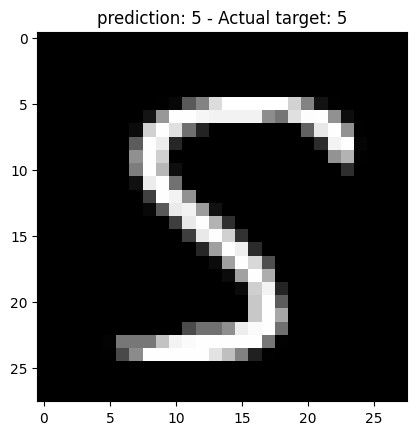

In [6]:
# retrieve index item

with torch.no_grad():
    index = 333
    item = test_dataset[index]
    image = item[0]
    true_target = item[1]
    prediction = classifier(image)
    predicted_class = np.argmax(prediction)  
    image = image.reshape(28, 28, 1)
    plt.imshow(image, cmap = 'gray')
    plt.title(f'prediction: {predicted_class} - Actual target: {true_target}')
    plt.show()

### Reshaping the image before converting it to mdf

In [7]:
# reshaping the input image to include the batch size of the input (the batch_size is 1 because we are predicting single image)

x = torch.randn(28,28)
x.unsqueeze_(0)
x = x.repeat(1, 1, 1, 1)
x.shape

torch.Size([1, 1, 28, 28])

### Passing the input into Pytorch model

In [8]:
# passing the input image into the pytorch model to get the output

output = classifier(x)

### Printing out the Pytorch output  using _val_info 

In [9]:
# passing the output into the _val_info to print some info about the output

print("Evaluated the graph in pytorch, output: %s" % (_val_info(output)))

Evaluated the graph in pytorch, output: tensor([[-3.2526,  4.9525, -1.2445, -2.1831, -0.3905,  2.5858, -0.3658, -2.2035,
         -2.3883, -2.3067]], grad_fn=<AddmmBackward0>)(Tensor)


### Convert PyTorch model to MDF

In [11]:
# converting the model to MDF
mdf_model, params_dict = pytorch_to_mdf(
        model=classifier,
        args=(x),
        trace=True,
    )

### Create graph from the model

In [12]:
#generating graph from the model
mdf_graph = mdf_model.graphs[0]

### Add input to the parameters dict 

In [13]:
# adding input to the parameters dict so we can feed it to the EvaluableGraph
params_dict["input1"] = x.numpy()

### Evaluating the Graph

In [14]:
#evaluating the model via the MDF scheduler
eg = EvaluableGraph(graph=mdf_graph, verbose=False)


eg.evaluate(initializer=params_dict)


Init graph: ClassifierGraph
Evaluating graph: ClassifierGraph, root nodes: ['Conv_9'], with array format numpy


### Getting the MDF Prediction

In [15]:
# getting the MDF output(prediction)
output_mdf = eg.output_enodes[0].get_output()
output_mdf

array([[-3.25255322,  4.9525466 , -1.24451768, -2.18309641, -0.39046279,
         2.58579373, -0.36577016, -2.2034595 , -2.38831997, -2.30671525]])

###  Printing out the MDF output using _val_info 

In [16]:
# printing out the output using val_info 
print("Evaluated the graph in MDF, output: %s" %(_val_info(output_mdf)))

Evaluated the graph in MDF, output: [[-3.25255322 ... -2.30671525]] (NP (1, 10) float64)


### Confirm if the result produced by Pytorch and MDF is the same

In [17]:
# checking if the result produced by pytorch and MDF is the same
assert np.allclose(
     output.detach().numpy(),
     output_mdf,
)
print("passed all comparison tests")

passed all comparison tests


From the cell above, it can be seen that the string *"passed all comparison tests"* was printed out, this shows that pytorch and MDF prediction is absolutely the same.

### Save the model to JSON

In [18]:
# saving the model in json file format
mdf_model.to_json_file("mnist.json")

'mnist.json'

# Save the model to yaml

In [19]:
#saving the model in yaml file format
mdf_model.to_yaml_file("mnist.yaml")

'mnist.yaml'

 ###  MDF Graph

Converting MDF graph: ClassifierGraph to graphviz (level: 1, format: png)
    Node: Conv_9
Converting .2 .3 .5 to hex color
Bkgd color: ['.2', '.3', '.5'] (#334c7f), font: white
    Node: Relu_10
Converting .4 .2 .1 to hex color
Bkgd color: ['.4', '.2', '.1'] (#663319), font: white
    Node: MaxPool_11
Converting .2 .3 .2 to hex color
Bkgd color: ['.2', '.3', '.2'] (#334c33), font: white
    Node: Conv_12
Converting .2 .3 .5 to hex color
Bkgd color: ['.2', '.3', '.5'] (#334c7f), font: white
    Node: Relu_13
Converting .4 .2 .1 to hex color
Bkgd color: ['.4', '.2', '.1'] (#663319), font: white
    Node: MaxPool_14
Converting .2 .3 .2 to hex color
Bkgd color: ['.2', '.3', '.2'] (#334c33), font: white
    Node: Reshape_16
Converting .4 .3 .3 to hex color
Bkgd color: ['.4', '.3', '.3'] (#664c4c), font: white
    Node: Gemm_17
Converting .2 .3 .5 to hex color
Bkgd color: ['.2', '.3', '.5'] (#334c7f), font: white
    Node: Relu_18
Converting .4 .2 .1 to hex color
Bkgd color: ['.4', '.2', '.

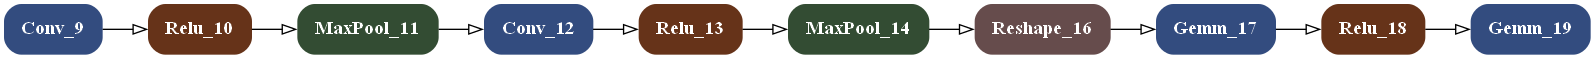

In [20]:
#generating MDF graph
mdf_model.to_graph_image(
    engine="dot",
    output_format="png",
    view_on_render=False,
    level=1,
    filename_root="pytorch_to_mdf",
    only_warn_on_fail=True,
    is_horizontal = True,
    solid_color = True,
)
from IPython.display import Image
Image(filename="pytorch_to_mdf.png")